In [1]:
import xml.etree.ElementTree as ET

tree = ET.parse("label2.xml")
root = tree.getroot()

In [7]:
size = root.findall("size")

for element in size:
    print(element.find("width").text)
    print(element.find("height").text)

2000
1414


In [8]:
objects = root.findall("object")
for object in objects:
    bndbox = object.find("bndbox")
    print(bndbox.find("xmin").text)
    print(bndbox.find("ymin").text)
    print(bndbox.find("xmax").text)
    print(bndbox.find("ymax").text)

30
31
371
203
29
202
372
372
27
373
373
550
28
551
375
721
29
721
377
892
28
891
380
1074
639
194
975
366
640
366
976
550
641
549
976
715
642
714
976
889
976
194
1307
367
975
366
1308
549
977
550
1309
719
975
716
1309
891
1606
31
1972
196
1606
194
1972
364
1607
363
1973
545
1606
544
1973
715
1607
715
1972
891
1606
891
1973
1067


In [11]:
width = 2000
height = 1414
ANCHO, ALTO = 2500, 1400

with open("labels.csv", "w") as file:
    objects = root.findall("object")
    for object in objects:
        bndbox = object.find("bndbox")
        f_xmin = bndbox.find("xmin").text
        f_ymin = bndbox.find("ymin").text
        f_xmax = bndbox.find("xmax").text
        f_ymax = bndbox.find("ymax").text
        file.write(f"{int(float(f_xmin)*ANCHO/width)},{int(float(f_ymin)*ALTO/height)},{int(float(f_xmax)*ANCHO/width)},{int(float(f_ymax)*ALTO/height)}\n")

In [26]:
import csv

parking = {}
with open("labels.csv", "r") as file:
    reader = csv.reader(file)
    for line in reader:
        parking[line[0]] = [tuple(line[1:]), True]

print(parking)

{'A8': [('37', '30', '463', '200'), True], 'A3': [('36', '200', '465', '368'), True], 'B2': [('33', '369', '466', '544'), True], 'C2': [('35', '545', '468', '713'), True], 'D2': [('36', '713', '471', '883'), True], 'E1': [('35', '882', '475', '1063'), True], 'A1': [('798', '192', '1218', '362'), True], 'A5': [('800', '362', '1220', '544'), True], 'B3': [('801', '543', '1220', '707'), True], 'C3': [('802', '706', '1220', '880'), True], 'A2': [('1220', '192', '1633', '363'), True], 'A6': [('1218', '362', '1635', '543'), True], 'B4': [('1221', '544', '1636', '711'), True], 'C4': [('1218', '708', '1636', '882'), True], 'A7': [('2007', '30', '2465', '194'), True], 'A4': [('2007', '192', '2465', '360'), True], 'B1': [('2008', '359', '2466', '539'), True], 'C1': [('2007', '538', '2466', '707'), True], 'D1': [('2008', '707', '2465', '882'), True], 'E2': [('2007', '882', '2466', '1056'), True]}


In [29]:
parking2 = {}
for key, value in parking.items():
    x1, y1, x2, y2 = value[0]
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    w = x2-x1
    h = y2-y1
    parking2[key] = [x1,y1,x2,y2,value[1],w,h]

In [30]:
parking2

{'A8': [37, 30, 463, 200, True, 426, 170],
 'A3': [36, 200, 465, 368, True, 429, 168],
 'B2': [33, 369, 466, 544, True, 433, 175],
 'C2': [35, 545, 468, 713, True, 433, 168],
 'D2': [36, 713, 471, 883, True, 435, 170],
 'E1': [35, 882, 475, 1063, True, 440, 181],
 'A1': [798, 192, 1218, 362, True, 420, 170],
 'A5': [800, 362, 1220, 544, True, 420, 182],
 'B3': [801, 543, 1220, 707, True, 419, 164],
 'C3': [802, 706, 1220, 880, True, 418, 174],
 'A2': [1220, 192, 1633, 363, True, 413, 171],
 'A6': [1218, 362, 1635, 543, True, 417, 181],
 'B4': [1221, 544, 1636, 711, True, 415, 167],
 'C4': [1218, 708, 1636, 882, True, 418, 174],
 'A7': [2007, 30, 2465, 194, True, 458, 164],
 'A4': [2007, 192, 2465, 360, True, 458, 168],
 'B1': [2008, 359, 2466, 539, True, 458, 180],
 'C1': [2007, 538, 2466, 707, True, 459, 169],
 'D1': [2008, 707, 2465, 882, True, 457, 175],
 'E2': [2007, 882, 2466, 1056, True, 459, 174]}

In [1]:
from collections import defaultdict

import cv2
import numpy as np

from ultralytics import YOLO

# Load the YOLO11 model
model = YOLO("ai_models\car_ai.pt")

# Open the video file
video_path = "video_prueba.mp4"
cap = cv2.VideoCapture(video_path)

# Store the track history
track_history = defaultdict(lambda: [])

# Loop through the video frames
while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()

    if success:
        # Run YOLO11 tracking on the frame, persisting tracks between frames
        result = model.track(frame, persist=True)[0]

        # Get the boxes and track IDs
        if result.boxes and result.boxes.is_track:
            boxes = result.boxes.xywh.cpu()
            track_ids = result.boxes.id.int().cpu().tolist()

            # Visualize the result on the frame
            frame = result.plot()

            # Plot the tracks
            for box, track_id in zip(boxes, track_ids):
                x, y, w, h = box
                track = track_history[track_id]
                track.append((float(x), float(y)))  # x, y center point
                if len(track) > 30:  # retain 30 tracks for 30 frames
                    track.pop(0)

                # Draw the tracking lines
                points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
                cv2.polylines(frame, [points], isClosed=False, color=(230, 230, 230), thickness=10)

        # Display the annotated frame
        cv2.imshow("YOLO11 Tracking", frame)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
cap.release()
cv2.destroyAllWindows()


0: 384x640 65 cars, 105.1ms
Speed: 2.0ms preprocess, 105.1ms inference, 63.9ms postprocess per image at shape (1, 3, 384, 640)


error: OpenCV(4.12.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1301: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


In [34]:
list(parking2.keys())

['A8',
 'A3',
 'B2',
 'C2',
 'D2',
 'E1',
 'A1',
 'A5',
 'B3',
 'C3',
 'A2',
 'A6',
 'B4',
 'C4',
 'A7',
 'A4',
 'B1',
 'C1',
 'D1',
 'E2']

(311, 106, 3)
(106, 518, 3)


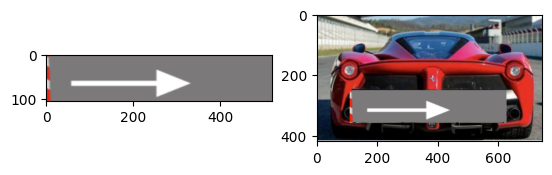

In [ ]:
import cv2
import matplotlib.pyplot as plt

ferrari_width = 747
ferrari_height = 419
ferrari_xmin = 108
ferrari_ymin = 251
ferrari_xmax = 626
ferrari_ymax = 357
wind_width = 2500
wind_height = 1400
x1 = int(1410*wind_width/2000)
y1 = int(850*wind_height/1414)
x2 = int(1480*wind_width/2000)
y2 = int(1070*wind_height/1414)
resized_x1 = int(x1*ferrari_width/wind_width) 
resized_y1 = int(y1*ferrari_height/wind_height)
resized_x2 = int(x2*ferrari_width/wind_width)
resized_y2 = int(y2*ferrari_height/wind_height)

wind_image = cv2.imread("A1.png")
wind_image = cv2.resize(wind_image, (wind_width, wind_height))
wind_image = cv2.cvtColor(wind_image, cv2.COLOR_BGR2RGB)
ferrari_image = cv2.imread("ferrari_plate.png")
ferrari_image = cv2.cvtColor(ferrari_image, cv2.COLOR_BGR2RGB)
wind_piece = wind_image[y1:y2, x1:x2]
wind_piece = cv2.rotate(wind_piece, cv2.ROTATE_90_CLOCKWISE)
wind_piece = cv2.resize(wind_piece, (ferrari_xmax-ferrari_xmin,ferrari_ymax-ferrari_ymin))
ax = plt.subplot(1,2,1)
ax.imshow(wind_piece)
ax = plt.subplot(1,2,2)
ax.imshow(ferrari_image)

print(ferrari_image[ferrari_xmin:ferrari_xmax, ferrari_ymin:ferrari_ymax].shape)
print(wind_piece.shape)


ferrari_image[ferrari_ymin:ferrari_ymax, ferrari_xmin:ferrari_xmax] = wind_piece

plt.imshow(ferrari_image)


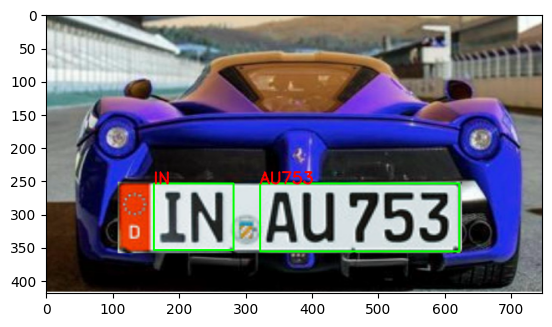

In [2]:
import cv2
import easyocr
import matplotlib.pyplot as plt

reader = easyocr.Reader(['es'])
img = cv2.imread('ferrari_plate.png')

results = reader.readtext(img)

for (bbox, text, prob) in results:
    (top_left, top_right, bottom_right, bottom_left) = bbox
    top_left = tuple(map(int, top_left))
    bottom_right = tuple(map(int, bottom_right))
    
    cv2.rectangle(img, top_left, bottom_right, (0, 255, 0), 2)
    cv2.putText(img, text, top_left, cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 2)
plt.imshow(img)


In [3]:
ANCHO, ALTO = 2500, 1400
print(int(591*ANCHO/2000))
print(int(68*ALTO/1414))
print(int(959*ANCHO/2000))
print(int(169*ALTO/1414))

print(int(978*ANCHO/2000))
print(int(69*ALTO/1414))
print(int(1311*ANCHO/2000))
print(int(172*ALTO/1414))

738
67
1198
167
1222
68
1638
170
